## Test de CNN cardIAc

- suit l'article donné en documentation

In [154]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import serial

In [155]:
path_to_datasets = "../../neural_network/dataset_publications/datas/train_data"

# Training data
train_X_val = np.load(f"{path_to_datasets}/X_val.npy")
train_X_signal = train_X_val[::,:-2] # remove frequency at the end to get a good looking signal
train_X_freq = train_X_val[::,-2:] # frequency handled separately
print("train_X_signal shape :", train_X_signal.shape)

train_Y_temp = np.load(f"{path_to_datasets}/y_train.npy")
print("train_Y_temp shape :", train_Y_temp.shape)

# Test data
test_X_PCA = np.load(f"{path_to_datasets}/X_test.npy")
test_Y_temp = np.load(f"{path_to_datasets}/y_test.npy")

train_X_signal shape : (5000, 181)
train_Y_temp shape : (5000,)


In [156]:
# Vectorize Y for training and test
# Classes :
# - [0] : 'A' (Atrial premature contraction)
# - [1] : 'L' (Left bundle branch block fluctuation)
# - [2] : 'N' (Normal)
# - [3] : 'R' (Right bundle branch block fluctuation)
# - [4] : 'V' (premature ventricular contraction)

def vectorize_Y(arr):
    mapping = {'A': [1, 0, 0, 0, 0],
               'L': [0, 1, 0, 0, 0],
               'N': [0, 0, 1, 0, 0],
               'R': [0, 0, 0, 1, 0],
               'V': [0, 0, 0, 0, 1]}
    
    res = np.array([mapping[val] for val in arr])
    return res

def devectorize_Y(vectorized_arr):
    mapping = {(1, 0, 0, 0, 0): 'A',
               (0, 1, 0, 0, 0): 'L',
               (0, 0, 1, 0, 0): 'N',
               (0, 0, 0, 1, 0): 'R',
               (0, 0, 0, 0, 1): 'V'}
    res = np.array([mapping[tuple(vec)] for vec in vectorized_arr])
    return res

# Vectorize train and test data
train_Y = vectorize_Y(train_Y_temp)
test_Y = vectorize_Y(test_Y_temp)


## Printing dataset samples

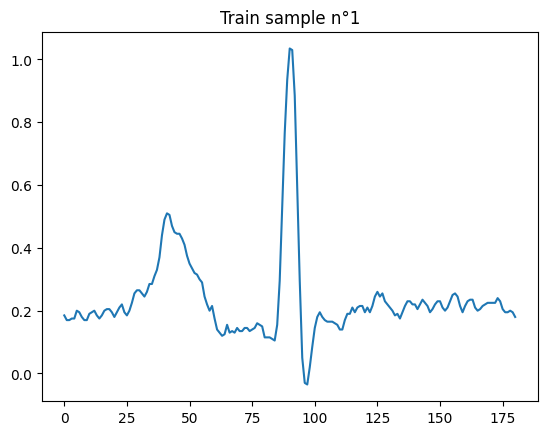

Time diff (prev/next) beat : [292. 301.]


In [157]:
index_shown = 1

plt.plot(np.arange(0, train_X_signal.shape[1]), train_X_signal[index_shown])
plt.title(f"Train sample n°{index_shown}")
plt.show()

print(f"Time diff (prev/next) beat : {train_X_freq[index_shown]}")

In [158]:
# Comptage des différentes classifications

def count_occurrences(arr):
    unique, counts = np.unique(arr, return_counts=True)
    return dict(zip(unique, counts))

count_occurrences(train_Y_temp)

{'A': 971, 'L': 995, 'N': 1038, 'R': 1029, 'V': 967}

# CNN 

In [166]:
# CNN Layers
# 2 inputs : signal and time between beats

input_layer = tf.keras.Input(shape=(train_X_signal.shape[1],1))
conv2 = tf.keras.layers.Conv2D(181, (21,4), activation='relu')(input_layer)
maxpooling1 = tf.keras.layers.MaxPooling1D(pool_size=86, strides=1, padding="valid")(conv2)
conv4 = tf.keras.layers.Conv2D(86, (21,4), activation='relu')(maxpooling1)
maxpooling2 = tf.keras.layers.MaxPooling1D(pool_size=29, strides=1, padding="valid")(conv4)
flat = tf.keras.layers.Flatten()(maxpooling2)

output_layer = tf.keras.layers.Dense(5,activation='softmax')(flat)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name="CNN-cardIAc-V1")

model.summary()

ValueError: Input 0 of layer "conv2d_10" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 181, 1)

Epoch 1/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2108 - loss: 1.6182 - val_accuracy: 0.2150 - val_loss: 1.6306
Epoch 2/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2211 - loss: 1.6191 - val_accuracy: 0.2150 - val_loss: 1.6121
Epoch 3/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2077 - loss: 1.6228 - val_accuracy: 0.1980 - val_loss: 1.6189
Epoch 4/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2054 - loss: 1.6183 - val_accuracy: 0.1850 - val_loss: 1.6376
Epoch 5/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2029 - loss: 1.6187 - val_accuracy: 0.1980 - val_loss: 1.6120
Epoch 6/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2021 - loss: 1.6145 - val_accuracy: 0.1850 - val_loss: 1.6205
Epoch 7/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1880 - loss: 1.6182 - val_accuracy: 0.1850 - val_loss: 1.6157
Epoch 8/15
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1946 - loss: 1.6159 - val_accu

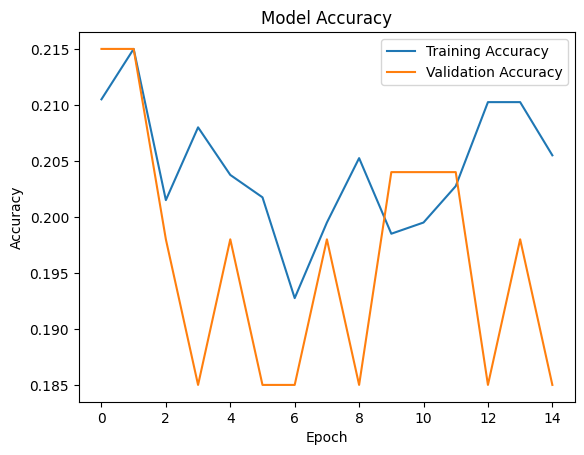

In [160]:
# Compile and train the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_X_signal, 
    train_Y, 
    epochs = 15, 
    batch_size=10,
    validation_split=0.2
)

# Plot the accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [161]:
model.save("CNN_cardIAc.keras")